# Libraries

In [1]:
pip install dotmap

In [2]:
import torchvision.transforms as T
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import TensorDataset, DataLoader
from functools import partial
from dotmap import DotMap
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

from tqdm import tqdm
import os


# Config

In [3]:

args = DotMap()
args.n_bits = 4
args.dataset = 'cifar10'
args.batch_size = 16
args.n_channels = 128
args.n_out_conv_channels = 512
args.kernel_size = 3
args.n_res_layers = 3
args.n_cond_classes = False
args.norm_layer = True
args.seed = 0
args.lr = 5e-4
args.polyak = 0.9995 # Decayfor moving average
args.log_interval = 1
args.eval_interval = 1
args.output_dir = '/content/drive/MyDrive/ADL/3_4/pixelcnn/'
args.mini_data = False
args.device = 'cuda'
args.image_dims = (3,32,32)
args.n_samples = 4


args.train = True
args.evaluate = False
args.generate = False

args.start_epoch = 0
args.n_epochs = 10
args.step = 0


# PixelCNN Architecture

A simplified PixelCNN Architecture

Some modifications include lowering dimension of channels in intermediate layers, and using only 3 residual layers

pixel values are quantized to 4 bits so model's output size is (batch, 16, 3, 32, 32)

In [4]:


############################### Model components #####################################


def pixelcnn_gate(x):
    a, b = x.chunk(2,1)
    return torch.tanh(a) * torch.sigmoid(b)

class MaskedConv2d(nn.Conv2d):
    def __init__(self, *args, mask_type=None, mask_n_channels=None, gated=False, **kwargs):
        super().__init__(*args, **kwargs)
        nn.init.constant_(self.bias, 0.)

        # set up mask -- cf PixelRNN paper Figure 2 Right: masks A and B
        self.mask_type = mask_type
        self.mask_n_channels = mask_n_channels
        center_row = self.kernel_size[0] // 2
        center_col = self.kernel_size[1] // 2

        mask = torch.ones_like(self.weight)         # shape (out_channels, in_channels, kernel_height, kernel_width)

        # mask out 1/ rows below the middle and 2/ center row pixels right of middle
        if center_row == 0:                         # case when kernel_size = (1,k) in horizontal stack
            mask[:, :, :, center_col+1:] = 0
        elif center_col == 0:                       # case when kernel_size = (k,1)
            mask[:, :, center_row+1:, :] = 0
        else:                                       # case when kernel_size = (k,k)
            mask[:, :, center_row+1:, :] = 0
            mask[:, :, center_row, center_col+1:] = 0

        # mask out center pixel in future channels -- mask A current channel is 0; mask B current channel is 1
        for i in range(mask_n_channels):
            for j in range(mask_n_channels):
                if (mask_type=='a' and i >= j) or (mask_type=='b' and i > j):
                    mask[j::mask_n_channels, i::mask_n_channels, center_row, center_col] = 0

        # mask out center row (vertical stack in a Gated Residual Layer); cf Conditional image generation with PixelCNN Decoders
        if mask_type == 'vstack':
            mask[:, :, center_row, :] = 0

        if gated:
            # pixelcnn gate splits the input in two along the channel dim;
            # ensure that both chunks receive the same mask by replicating the first half of the mask over the second
            mask = mask.chunk(2,0)[0].repeat(2,1,1,1)

        # final mask
        self.register_buffer('mask', mask)

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

    def __repr__(self):
        s = super().__repr__()
        return s[:-1] + ', mask_type={}, mask_n_channels={}'.format(self.mask_type, self.mask_n_channels) + s[-1]


class GatedResidualLayer(nn.Module):
    """ Figure 2 in Conditional image generation with PixelCNN Decoders """
    def __init__(self, in_channels, out_channels, kernel_size, mask_type, mask_n_channels, n_cond_classes, norm_layer):
        super().__init__()
        self.residual = (in_channels==out_channels)
        self.norm_layer = norm_layer

        self.v   = MaskedConv2d(in_channels, 2*out_channels, kernel_size, padding=kernel_size//2,
                                mask_type='vstack', mask_n_channels=mask_n_channels, gated=True)
        self.h   = MaskedConv2d(in_channels, 2*out_channels, (1, kernel_size), padding=(0, kernel_size//2),
                                mask_type=mask_type, mask_n_channels=mask_n_channels, gated=True)
        self.v2h = MaskedConv2d(2*out_channels, 2*out_channels, kernel_size=1,
                                mask_type=mask_type, mask_n_channels=mask_n_channels, gated=True)
        self.h2h = MaskedConv2d(out_channels, out_channels, kernel_size=1,
                                mask_type=mask_type, mask_n_channels=mask_n_channels, gated=False)

        if n_cond_classes:
            self.proj_h = nn.Linear(n_cond_classes, 2*out_channels)

        if self.norm_layer:
            self.norm_layer_v = nn.BatchNorm2d(out_channels)
            self.norm_layer_h = nn.BatchNorm2d(out_channels)

    def forward(self, x_v, x_h, h=None):
        # projection of h if included for conditional generation (cf paper section 2.3 -- added before the pixelcnn_gate)
        proj_y = self.proj_h(h)[:,:,None,None] if h is not None else 0

        # vertical stack
        x_v_out = self.v(x_v)
        x_v2h = self.v2h(x_v_out) + proj_y
        x_v_out = pixelcnn_gate(x_v_out)

        # horizontal stack
        x_h_out = self.h(x_h) + x_v2h + proj_y
        x_h_out = pixelcnn_gate(x_h_out)
        x_h_out = self.h2h(x_h_out)

        # residual connection
        if self.residual:
            x_h_out = x_h_out + x_h

        # normalization
        if self.norm_layer:
            x_v_out = self.norm_layer_v(x_v_out)
            x_h_out = self.norm_layer_h(x_h_out)

        return x_v_out, x_h_out

    def extra_repr(self):
        return 'residual={}, norm_layer={}'.format(self.residual, self.norm_layer)



################################### PixelCNN ##########################################


class PixelCNN(nn.Module):
    def __init__(self, image_dims, n_bits, n_channels, n_out_conv_channels, kernel_size, n_res_layers, n_cond_classes, norm_layer=True):
        super().__init__()
        C, H, W = image_dims

        self.input_conv = MaskedConv2d(C, 2*n_channels, kernel_size=7, padding=3, mask_type='a', mask_n_channels=C, gated=True)
        self.res_layers = nn.ModuleList([
            GatedResidualLayer(n_channels, n_channels, kernel_size, 'b', C, n_cond_classes, norm_layer)
            for _ in range(n_res_layers)])
        self.conv_out1 = MaskedConv2d(n_channels, 2*n_out_conv_channels, kernel_size=1, mask_type='b', mask_n_channels=C, gated=True)
        self.conv_out2 = MaskedConv2d(n_out_conv_channels, 2*n_out_conv_channels, kernel_size=1, mask_type='b', mask_n_channels=C, gated=True)
        self.output = MaskedConv2d(n_out_conv_channels, C * 2**n_bits, kernel_size=1, mask_type='b', mask_n_channels=C)

        if n_cond_classes:
            self.proj_h = nn.Linear(n_cond_classes, 2*n_channels)

    def forward(self, x, h=None):
        B, C, H, W = x.shape

        x = pixelcnn_gate(self.input_conv(x) + (self.proj_h(h)[:,:,None,None] if h is not None else 0.))
        x_v, x_h = x, x

        for l in self.res_layers:
            x_v, x_h = l(x_v, x_h)

        out = pixelcnn_gate(self.conv_out1(x_h))
        out = pixelcnn_gate(self.conv_out2(out))
        out = self.output(out)

        return out.reshape(B, -1, C, H, W)



###################### Loss and generation functions ##############################


def loss_fn_pixel(logits, targets):
    """
    Args
        logits -- model output of shape (B, 2**n_bits, C, H, W)
        targets -- data tensor of shape (B, C, H, W) with values in pixel space [0, 2**n_bits)
    """
    return F.cross_entropy(logits, targets, reduction='none').sum([1,2,3])

def generate_fn(model, n_samples, image_dims, device, preprocess_fn, n_bits, h=None):
    out = torch.zeros(n_samples, *image_dims, device=device)
    with tqdm(total=(image_dims[0]*image_dims[1]*image_dims[2]), desc='Generating {} images'.format(n_samples)) as pbar:
        for yi in range(image_dims[1]):
            for xi in range(image_dims[2]):
                for ci in range(image_dims[0]):
                    logits = model(out, h)
                    probs = F.softmax(logits, dim=1)
                    sample = torch.multinomial(probs[:,:,ci,yi,xi], num_samples=1).squeeze()
                    out[:,ci,yi,xi] = preprocess_fn(sample, n_bits)
                    pbar.update()
    return out


print('testing... output size: ')
net = PixelCNN(args.image_dims, args.n_bits, args.n_channels, args.n_out_conv_channels, args.kernel_size,
                          args.n_res_layers, args.n_cond_classes, args.norm_layer)
y = net(torch.randn(1, 3, 32, 32))
print(y.size())

testing... output size: 
torch.Size([1, 16, 3, 32, 32])


## Optimizer

EMA optimizer is used

In [5]:


def build_ema_optimizer(optimizer_cls):
    class Optimizer(optimizer_cls):
        def __init__(self, *args, polyak=0.0, **kwargs):
            if not 0.0 <= polyak <= 1.0:
                raise ValueError("Invalid polyak decay rate: {}".format(polyak))
            super().__init__(*args, **kwargs)
            self.defaults['polyak'] = polyak

        def step(self, closure=None):
            super().step(closure)

            # update exponential moving average after gradient update to parameters
            for group in self.param_groups:
                for p in group['params']:
                    state = self.state[p]

                    # state initialization
                    if 'ema' not in state:
                        state['ema'] = torch.zeros_like(p.data)

                    # ema update
                    state['ema'] -= (1 - self.defaults['polyak']) * (state['ema'] - p.data)

        def swap_ema(self):
            """ substitute exponential moving average values into parameter values """
            for group in self.param_groups:
                for p in group['params']:
                    data = p.data
                    state = self.state[p]
                    p.data = state['ema']
                    state['ema'] = data

        def __repr__(self):
            s = super().__repr__()
            return self.__class__.__mro__[1].__name__ + ' (\npolyak: {}\n'.format(self.defaults['polyak']) + s.partition('\n')[2]

    return Optimizer

RMSprop = build_ema_optimizer(torch.optim.RMSprop)


# Data

Some pre and post processing functions and a function to load and quantize Cifar10

In [6]:


def fetch_dataloaders():
    # preprocessing transforms
    transform = T.Compose([T.ToTensor(),                                            # tensor in [0,1]
                           lambda x: x.mul(255).div(2**(8-args.n_bits)).floor(),    # lower bits
                           partial(preprocess, n_bits=args.n_bits)])                # to model space [-1,1]

    if args.dataset=='cifar10':
        args.image_dims = (3,32,32)
        train_dataset = CIFAR10('./', train=True, download=True, transform=transform)
        valid_dataset = CIFAR10('./', train=False, download=True, transform=transform)

    if args.mini_data:  # dataset to a single batch
        train_dataset.data = train_dataset.data[:args.batch_size]
        train_dataset.targets = train_dataset.targets[:args.batch_size]
        valid_dataset = train_dataset

    print('Dataset {}\n\ttrain len: {}\n\tvalid len: {}\n\tshape: {}'.format(
        args.dataset, len(train_dataset), len(valid_dataset), train_dataset[0][0].shape))

    train_dataloader = DataLoader(train_dataset, args.batch_size, shuffle=True, pin_memory=(args.device=='cuda'), num_workers=4)
    valid_dataloader = DataLoader(valid_dataset, args.batch_size, shuffle=False, pin_memory=(args.device=='cuda'), num_workers=4)

    return train_dataloader, valid_dataloader

def preprocess(x, n_bits):
    # 1. convert data to float
    # 2. normalize to [0,1] given quantization
    # 3. shift to [-1,1]
    return x.float().div(2**n_bits - 1).mul(2).add(-1)

def deprocess(x, n_bits):
    # 1. shift to [0,1]
    # 2. quantize to n_bits
    # 3. convert data to long
    return x.add(1).div(2).mul(2**n_bits - 1).long()


# Prepare model and data

In [7]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)

if args.device == 'cuda':
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

train_dataloader, test_dataloader = fetch_dataloaders()

# Model
model = PixelCNN(args.image_dims, args.n_bits, args.n_channels, args.n_out_conv_channels, args.kernel_size,
                          args.n_res_layers, args.n_cond_classes, args.norm_layer).to(args.device)
# images need to be deprocessed to [0, 2**n_bits) for loss fn
loss_fn = lambda scores, targets, n_bits: loss_fn_pixel(scores, deprocess(targets, n_bits))
# multinomial sampling needs to be processed to [-1,1] at generation
generate_fn = partial(generate_fn, preprocess_fn=preprocess, n_bits=args.n_bits)
optimizer = RMSprop(model.parameters(), lr=args.lr, polyak=args.polyak)
scheduler = None

# print(model)
print('Model parameters: {:,}'.format(sum(p.numel() for p in model.parameters())))
print(model)


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified
Dataset cifar10
	train len: 50000
	valid len: 10000
	shape: torch.Size([3, 32, 32])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Model parameters: 2,149,552
PixelCNN(
  (input_conv): MaskedConv2d(3, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), mask_type=a, mask_n_channels=3)
  (res_layers): ModuleList(
    (0): GatedResidualLayer(
      residual=True, norm_layer=True
      (v): MaskedConv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), mask_type=vstack, mask_n_channels=3)
      (h): MaskedConv2d(128, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), mask_type=b, mask_n_channels=3)
      (v2h): MaskedConv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), mask_type=b, mask_n_channels=3)
      (h2h): MaskedConv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), mask_type=b, mask_n_channels=3)
      (norm_layer_v): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm_layer_h): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): GatedResidualLayer(
      residual=True, norm_layer=True
      (v): MaskedConv2d(1

# Train Functions

functions for training self-supervised PixelCNN and supervised ResNet18 finetuning

2 modes are investigated for self-supervised stage

Mode 1: pixelCNN is fed with whole images are tries to reconstruct the whole image

Mode 2: PixelCNN is fed with only top half of images and tries to reconstruct the whole image

In [8]:


############################### Self-supervised Training ################################

def train_epoch(model, dataloader, optimizer, scheduler, loss_fn, epoch):
    model.train()

    #________________ Iterate on train data ______________________

    with tqdm(total=len(dataloader), desc='epoch {}/{}'.format(epoch, args.start_epoch + args.n_epochs)) as pbar:
        for x,y in dataloader:

            args.step += 1

            x = x.to(args.device)
            x_numpy = x[0].permute(1, 2, 0).detach().to('cpu').numpy() # Save image for illustration

          
            #_________________________________What is good representation? ________________________________________#

            if half_representation:  # Only input top half of image to model and try to recover all of data

                half_x = torch.zeros((args.batch_size, 3, 32, 32), device=args.device).float()
                half_x[:, :, :16, :] = x[:, :, :16, :]

                half_x_numpy = half_x[0].permute(1, 2, 0).detach().to('cpu').numpy() # Save for illustration

                logits = model(half_x, None)

                # For ilustration
                probs = F.softmax(logits, dim=1)
                sample = torch.argmax(probs, dim=1).squeeze()
                logit_numpy = preprocess(sample, args.n_bits)
                logit_numpy = logit_numpy[0].permute(1, 2, 0).detach().to('cpu').numpy()

                
            else: # Input all data and try to recover all of data

                logits = model(x, None)

            loss = loss_fn(logits, x, args.n_bits).mean(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler: scheduler.step()

            pbar.set_postfix(bits_per_dim='{:.4f}'.format(loss / (np.log(2) * np.prod(args.image_dims))))
            pbar.update()


        # record
        print('train_bits_per_dim', loss / (np.log(2) * np.prod(args.image_dims)), args.step)
        print('lr', optimizer.param_groups[0]['lr'], args.step)

        # Show 1 example
        plt.figure(figsize=(4, 10))
        if half_representation:
            plt.subplot(1, 3, 1)
            plt.imshow(x_numpy)
            plt.title('original X')
            plt.subplot(1, 3, 2)
            plt.imshow(half_x_numpy)
            plt.title('input')
            plt.subplot(1, 3, 3)
            plt.imshow(logit_numpy)
            plt.title('output')
            plt.show()



def train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, scheduler, loss_fn, generate_fn):
    for epoch in range(args.start_epoch, args.start_epoch + args.n_epochs):
        # train
        train_epoch(model, train_dataloader, optimizer, scheduler, loss_fn, epoch)

        if (epoch+1) % args.eval_interval == 0:
            # save model
            torch.save({'epoch': epoch,
                        'global_step': args.step,
                        'state_dict': model.state_dict()},
                        os.path.join(args.output_dir, 'checkpoint.pt'))
            torch.save(optimizer.state_dict(), os.path.join(args.output_dir, 'optim_checkpoint.pt'))

            # swap params to ema values
            optimizer.swap_ema()

            # evaluate
            eval_loss = evaluate(model, test_dataloader, loss_fn)
            print('eval_bits_per_dim', eval_loss / (np.log(2) * np.prod(args.image_dims)), args.step)

            # generate
            samples = generate(model, generate_fn)
            save_image(samples, os.path.join(args.output_dir, 'generation_sample_step_{}.png'.format(args.step)))

            # restore params to gradient optimized
            optimizer.swap_ema()




######################### Evaluate (self-supervised) ##############


@torch.no_grad()
def evaluate(model, dataloader, loss_fn):
    model.eval()

    losses = 0
    for x,y in tqdm(dataloader, desc='Evaluate'):
        x = x.to(args.device)
        logits = model(x, None)
        losses += loss_fn(logits, x, args.n_bits).mean(0).item()
    return losses / len(dataloader)



########################## Generate Samples #######################


@torch.no_grad()
def generate(model, generate_fn):
    model.eval()
    samples = generate_fn(model, args.n_samples, args.image_dims, args.device)
    return make_grid(samples.cpu(), normalize=True, scale_each=True, nrow=args.n_samples)



######################## Supervised FineTuning with ResNet18 ####################


def finetune_resnet18(pixelmodel, train_dataloader, test_dataloader):

      classifier = torchvision.models.resnet18(pretrained = True)
      classifier.fc = nn.Linear(512, 10)
      classifier = classifier.to('cuda')
      classifier.train()
      pixelmodel.eval()

      # freeze all pixelcnn layers
      for name, param in pixelmodel.named_parameters():
          param.requires_grad = False

      # freeze all ResNet18 layers but the last fc
      for name, param in classifier.named_parameters():
          if ('linear' not in name) and ('classifier' not in name) and ('fc' not in name): 
              param.requires_grad = False
          else:
              param.requires_grad = True

      # Loss & optimizer
      criterion = nn.CrossEntropyLoss() # mean square error loss
      optimizer = torch.optim.Adam(classifier.parameters(), lr=args.lr)

      #train
      for epoch in range(0, 20):
          
          train_loss = 0
          correct = 0
          total = 0
          loss = 0
          for i, (x, y) in enumerate(train_dataloader):

              x = x.to('cuda')
              y = y.to('cuda')
      
              logits = pixelmodel(x, None)

              probs = F.softmax(logits, dim=1)
              sample = torch.argmax(probs, dim=1).squeeze()
              x_resnet = preprocess(sample, args.n_bits)
              x_resnet = x_resnet.detach() # Treat this like input data for classifier

              out = classifier(x_resnet)

              loss = criterion(out, y)
              loss.backward()
              optimizer.step()

              _, predicted = out.max(1)
              total += y.size(0)
              correct += predicted.eq(y).sum().item()

          train_accuracy = 100.*correct/total
          test_accuracy = 0
          correct = 0
          total = 0

          # Test phase
          for batch_idx, (inputs, targets) in enumerate(test_dataloader):

              inputs = inputs.to('cuda')
              targets = targets.to('cuda')


              logits = pixelmodel(inputs, None)

              probs = F.softmax(logits, dim=1)
              sample = torch.argmax(probs, dim=1).squeeze()
              x_resnet = preprocess(sample, args.n_bits)
              x_resnet = x_resnet.detach() # Treat this like input data for classifier

              out = classifier(x_resnet)

            
              _, predicted = out.max(1)
              total += targets.size(0)
              correct += predicted.eq(targets).sum().item()

          test_accuracy = 100.*correct/total

          print(f"Epoch {epoch}\t Train accuracy {train_accuracy}\t Test accuracy: {test_accuracy}")
                  


# Self-supervised training -> Mode 1: Feeding pixelCNN with whole images

14 epochs


In [46]:
half_representation = False # Use all data to predict all data

args.output_dir = '/content/drive/MyDrive/ADL/3_4/pixelcnn/'
args.restore_file = os.path.join(args.output_dir, 'checkpoint.pt')

args.start_epoch = 0
args.n_epochs = 10
args.step = 0

if args.restore_file: # Resume training
    print('loading from checkpoint')
    model_checkpoint = torch.load(args.restore_file, map_location=args.device)
    model.load_state_dict(model_checkpoint['state_dict'])
    optimizer.load_state_dict(torch.load(os.path.dirname(args.restore_file) + '/optim_checkpoint.pt', map_location=args.device))
    args.start_epoch = model_checkpoint['epoch'] + 1
    args.step = model_checkpoint['global_step']
    print('epoch and loss: ')
    print(args.start_epoch, )

if args.train:
    train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, scheduler, loss_fn, generate_fn)


epoch 10/20:   0%|          | 0/3125 [00:00<?, ?it/s]

loading from checkpoint
epoch and loss: 
10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Evaluate:   0%|          | 0/625 [00:00<?, ?it/s]

train_bits_per_dim tensor(0.9041, device='cuda:0', grad_fn=<DivBackward0>) 34375
lr 0.0005 34375


Generating 4 images:   0%|          | 11/3072 [00:00<00:30, 100.64it/s]

eval_bits_per_dim 1.001658215623344 34375


Evaluate:   0%|          | 0/625 [00:00<?, ?it/s]

train_bits_per_dim tensor(0.9840, device='cuda:0', grad_fn=<DivBackward0>) 37500
lr 0.0005 37500


Generating 4 images:   0%|          | 11/3072 [00:00<00:29, 103.25it/s]

eval_bits_per_dim 0.9944010859021137 37500


Evaluate:   0%|          | 0/625 [00:00<?, ?it/s]

train_bits_per_dim tensor(1.0354, device='cuda:0', grad_fn=<DivBackward0>) 40625
lr 0.0005 40625


Generating 4 images:   0%|          | 11/3072 [00:00<00:29, 102.59it/s]

eval_bits_per_dim 0.989891835447441 40625


Evaluate:   0%|          | 0/625 [00:00<?, ?it/s]

train_bits_per_dim tensor(1.1000, device='cuda:0', grad_fn=<DivBackward0>) 43750
lr 0.0005 43750


Generating 4 images:   0%|          | 11/3072 [00:00<00:29, 102.42it/s]

eval_bits_per_dim 1.008334853174496 43750


epoch 14/20:   3%|▎         | 90/3125 [00:09<05:06,  9.91it/s, bits_per_dim=0.9425]


KeyboardInterrupt: ignored

# Self-supervised training -> Mode 2: Feeding pixelCNN with only top half of images

14 epochs

reconstructed images still in the bottom contain 0 pixels! this is because model was not deep enough to propagate information from top to bottom of image!

But it is still ok! Generated images (not present here) when feeding image pixels by correct ordering look aweseome!

loading from checkpoint


epoch 4/14:   0%|          | 0/3125 [00:00<?, ?it/s]

epoch and loss: 
4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch 4/14: 100%|█████████▉| 3124/3125 [04:09<00:00, 12.35it/s, bits_per_dim=2.2612]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_bits_per_dim tensor(2.2612, device='cuda:0', grad_fn=<DivBackward0>) 15625
lr 0.0005 15625


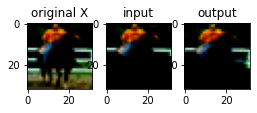

Generating 4 images:   1%|          | 16/3072 [00:00<00:19, 155.33it/s]

eval_bits_per_dim 1.0514211719354656 15625


epoch 5/14: 100%|██████████| 3125/3125 [04:17<00:00, 12.22it/s, bits_per_dim=2.1673]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_bits_per_dim tensor(2.1673, device='cuda:0', grad_fn=<DivBackward0>) 18750
lr 0.0005 18750


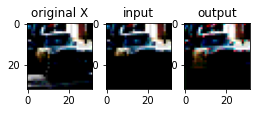

Generating 4 images:   1%|          | 16/3072 [00:00<00:19, 159.35it/s]

eval_bits_per_dim 1.0302559519974885 18750


epoch 6/14: 100%|██████████| 3125/3125 [04:17<00:00, 12.31it/s, bits_per_dim=2.2290]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_bits_per_dim tensor(2.2290, device='cuda:0', grad_fn=<DivBackward0>) 21875
lr 0.0005 21875


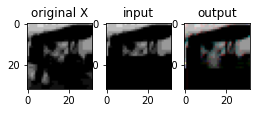

Generating 4 images:   1%|          | 16/3072 [00:00<00:19, 158.67it/s]

eval_bits_per_dim 1.0319661959079829 21875


epoch 7/14: 100%|██████████| 3125/3125 [04:17<00:00, 12.22it/s, bits_per_dim=2.2239]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_bits_per_dim tensor(2.2239, device='cuda:0', grad_fn=<DivBackward0>) 25000
lr 0.0005 25000


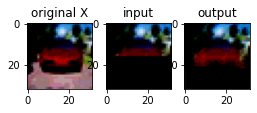

Generating 4 images:   1%|          | 16/3072 [00:00<00:19, 156.20it/s]

eval_bits_per_dim 1.0238450720363745 25000


epoch 8/14: 100%|██████████| 3125/3125 [04:17<00:00, 12.29it/s, bits_per_dim=2.3038]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_bits_per_dim tensor(2.3038, device='cuda:0', grad_fn=<DivBackward0>) 28125
lr 0.0005 28125


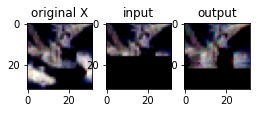

Generating 4 images:   1%|          | 17/3072 [00:00<00:19, 160.59it/s]

eval_bits_per_dim 1.0156165157851826 28125


epoch 9/14: 100%|██████████| 3125/3125 [04:18<00:00, 12.30it/s, bits_per_dim=2.2789]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_bits_per_dim tensor(2.2789, device='cuda:0', grad_fn=<DivBackward0>) 31250
lr 0.0005 31250


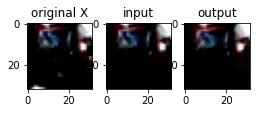

Generating 4 images:   1%|          | 17/3072 [00:00<00:19, 160.47it/s]

eval_bits_per_dim 1.0269423360302277 31250


epoch 10/14: 100%|██████████| 3125/3125 [04:18<00:00, 12.25it/s, bits_per_dim=2.1654]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_bits_per_dim tensor(2.1654, device='cuda:0', grad_fn=<DivBackward0>) 34375
lr 0.0005 34375


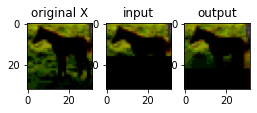

Generating 4 images:   1%|          | 17/3072 [00:00<00:18, 161.81it/s]

eval_bits_per_dim 1.0108953771094782 34375


epoch 11/14: 100%|██████████| 3125/3125 [04:19<00:00, 12.02it/s, bits_per_dim=2.2348]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_bits_per_dim tensor(2.2348, device='cuda:0', grad_fn=<DivBackward0>) 37500
lr 0.0005 37500


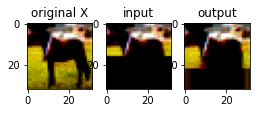

Generating 4 images:   1%|          | 16/3072 [00:00<00:19, 156.97it/s]

eval_bits_per_dim 1.0087695126787064 37500


epoch 12/14: 100%|██████████| 3125/3125 [04:21<00:00, 12.24it/s, bits_per_dim=2.2713]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_bits_per_dim tensor(2.2713, device='cuda:0', grad_fn=<DivBackward0>) 40625
lr 0.0005 40625


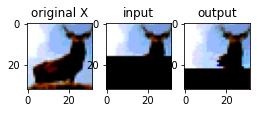

Generating 4 images:   1%|          | 16/3072 [00:00<00:19, 159.44it/s]

eval_bits_per_dim 1.00978259707567 40625


epoch 13/14: 100%|██████████| 3125/3125 [04:21<00:00, 12.05it/s, bits_per_dim=2.3405]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_bits_per_dim tensor(2.3405, device='cuda:0', grad_fn=<DivBackward0>) 43750
lr 0.0005 43750


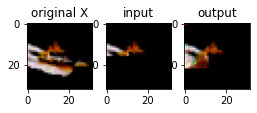

Generating 4 images:   1%|          | 17/3072 [00:00<00:19, 159.75it/s]

eval_bits_per_dim 1.0035681703742243 43750


Generating 4 images: 100%|██████████| 3072/3072 [00:20<00:00, 148.23it/s]


In [9]:
args.output_dir = '/content/drive/MyDrive/ADL/3_4/pixelcnn_half/'

args.restore_file = os.path.join(args.output_dir, 'checkpoint.pt')

half_representation = True # Use all data to predict all data

args.start_epoch = 0
args.n_epochs = 10
args.step = 0

if args.restore_file: # Resume training
    print('loading from checkpoint')
    model_checkpoint = torch.load(args.restore_file, map_location=args.device)
    model.load_state_dict(model_checkpoint['state_dict'])
    optimizer.load_state_dict(torch.load(os.path.dirname(args.restore_file) + '/optim_checkpoint.pt', map_location=args.device))
    args.start_epoch = model_checkpoint['epoch'] + 1
    args.step = model_checkpoint['global_step']
    print('epoch and loss: ')
    print(args.start_epoch, )

if args.train:
    train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, scheduler, loss_fn, generate_fn)


# Mode 1 Finetuned ResNet18 Classifier

5 epochs only... (I have 1 hour left to the deadline =)) ) Test accuracy: 32.76

Random results...

In [9]:
args.output_dir = '/content/drive/MyDrive/ADL/3_4/pixelcnn/'

args.restore_file = os.path.join(args.output_dir, 'checkpoint.pt')

half_representation = False # Use all data to predict all data

args.start_epoch = 0
args.n_epochs = 10
args.step = 0

if args.restore_file: # Load from checkpoint
    print('loading from checkpoint')
    model_checkpoint = torch.load(args.restore_file, map_location=args.device)
    model.load_state_dict(model_checkpoint['state_dict'])
    optimizer.load_state_dict(torch.load(os.path.dirname(args.restore_file) + '/optim_checkpoint.pt', map_location=args.device))
    args.start_epoch = model_checkpoint['epoch'] + 1
    args.step = model_checkpoint['global_step']
    print('epoch and loss: ')
    print(args.start_epoch, )

# Train classifier
finetune_resnet18(model, train_dataloader, test_dataloader)



loading from checkpoint
epoch and loss: 
14


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0	 Train accuracy 24.71	 Test accuracy: 32.75
Epoch 1	 Train accuracy 30.322	 Test accuracy: 27.69
Epoch 2	 Train accuracy 30.34	 Test accuracy: 32.76
Epoch 3	 Train accuracy 30.208	 Test accuracy: 30.5
Epoch 4	 Train accuracy 30.632	 Test accuracy: 28.86
Epoch 5	 Train accuracy 29.73	 Test accuracy: 25.85


Exception in thread Thread-26:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/pytho

KeyboardInterrupt: ignored

# Mode 2 Finetuned ResNet18 Classifier

5 epochs Test accuracy: 34.54

Random results...

In [10]:
args.output_dir = '/content/drive/MyDrive/ADL/3_4/pixelcnn_half/'

args.restore_file = os.path.join(args.output_dir, 'checkpoint.pt')

half_representation = True # Use all data to predict all data

args.start_epoch = 0
args.n_epochs = 10
args.step = 0

if args.restore_file: # Load from checkpoint
    print('loading from checkpoint')
    model_checkpoint = torch.load(args.restore_file, map_location=args.device)
    model.load_state_dict(model_checkpoint['state_dict'])
    optimizer.load_state_dict(torch.load(os.path.dirname(args.restore_file) + '/optim_checkpoint.pt', map_location=args.device))
    args.start_epoch = model_checkpoint['epoch'] + 1
    args.step = model_checkpoint['global_step']
    print('epoch and loss: ')
    print(args.start_epoch, )

# Train classifier
finetune_resnet18(model, train_dataloader, test_dataloader)



loading from checkpoint
epoch and loss: 
14


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0	 Train accuracy 23.776	 Test accuracy: 30.28
Epoch 1	 Train accuracy 30.206	 Test accuracy: 30.23
Epoch 2	 Train accuracy 31.624	 Test accuracy: 34.54
Epoch 3	 Train accuracy 30.758	 Test accuracy: 30.49
Epoch 4	 Train accuracy 30.116	 Test accuracy: 27.53
Epoch 5	 Train accuracy 30.266	 Test accuracy: 29.11
Epoch 6	 Train accuracy 29.516	 Test accuracy: 29.78


KeyboardInterrupt: ignored